In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d


In [3]:
# Load the CSV file into a NumPy array
id = 5

rho = np.loadtxt(f'highway/dataset_idm/spaciotemporal{id}.csv', delimiter=',', skiprows=1) 
control = np.load(f'highway/dataset_idm/traffic_light_status_{id}.npz')  
control = control['traffic_light_status']

# print shapes
print(rho.shape)
print(control.shape)

(300, 900)
(900,)


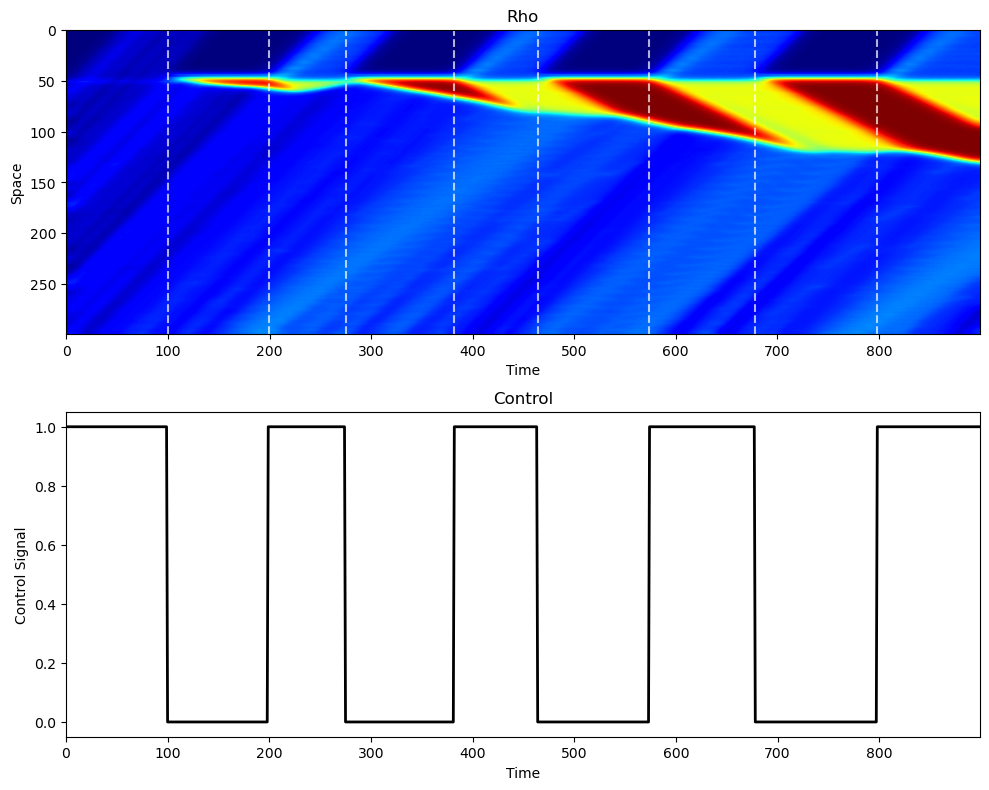

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot rho
ax1.imshow(np.flipud(rho), cmap='jet')
ax1.set_title('Rho')
ax1.set_ylabel('Space')
ax1.set_xlabel('Time')

# Identify the time indices where control changes
change_indices = np.where(np.diff(control) != 0)[0] + 1

# Plot vertical lines on ax1
for index in change_indices:
    ax1.axvline(x=index, color='white', linestyle='--', alpha=0.7)  # Adjust color and style as needed

# Plot control
ax2.plot(control, 'k', linewidth=2)
ax2.set_title('Control')
ax2.set_ylabel('Control Signal')
ax2.set_xlabel('Time')
ax2.set_xlim([0, 899])

plt.tight_layout()
plt.show()


In [5]:
def load_and_process_probe_data(file_path):
    # Load the CSV file into a list
    data = []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            data.append(row)
    
    # Convert data to a NumPy array of floats
    data = np.array(data).astype(np.float)

    # Initialize lists to store processed probe data
    probe_x = []  # position
    probe_t = []  # time
    probe_u = []  # density
    probe_v = []  # speed

    pv_x = []
    pv_t = []
    pv_u = []
    pv_v = []

    t_prev = 0
    # Process the data
    for meas in data:
        t = meas[1]
        if t - t_prev < 0:
            probe_x.append(np.array(pv_x).reshape((-1, 1)))
            pv_x = []
            probe_t.append(np.array(pv_t).reshape((-1, 1)))
            pv_t = []
            probe_u.append(np.array(pv_u).reshape((-1, 1)))
            pv_u = []
            probe_v.append(np.array(pv_v).reshape((-1, 1)))
            pv_v = []
        
        # Append measurements
        pv_x.append(meas[0])
        pv_t.append(meas[1])
        pv_u.append(meas[2])
        pv_v.append(meas[3])
        t_prev = t

    # Append the last batch of data
    probe_x.append(np.array(pv_x).reshape((-1, 1)))
    probe_t.append(np.array(pv_t).reshape((-1, 1)))
    probe_u.append(np.array(pv_u).reshape((-1, 1)))
    probe_v.append(np.array(pv_v).reshape((-1, 1)))

    return probe_t, probe_x, probe_u, probe_v

# Example usage
probe_t, probe_x, probe_u, probe_v = load_and_process_probe_data(f'highway/dataset_idm/pv{id}.csv')

In [6]:
def create_coords_and_values(probe_t, probe_x, probe_u, probe_v):
    # Initialize lists to hold coordinates and values
    coords = []
    values = []

    # Loop over each probe and process the data
    for idx, (t, x, u, v) in enumerate(zip(probe_t, probe_x, probe_u, probe_v)):
        # Create an ID array for the current probe
        id_array = np.full_like(t, idx, dtype=np.float16).reshape(-1, 1)

        # Stack the time, space, and ID coordinates into one array
        coords.append(np.hstack((t.reshape(-1, 1), x.reshape(-1, 1), id_array)))

        # Stack the density (u) and speed (v) values into one array
        values.append(np.hstack((u.reshape(-1, 1), v.reshape(-1, 1))))

    # Concatenate all probes' data into single arrays
    coords = np.concatenate(coords, axis=0)
    values = np.concatenate(values, axis=0)

    return coords, values


In [7]:
coords, values = create_coords_and_values(probe_t, probe_x, probe_u, probe_v)
# print shapes
print(f"coords shape: {coords.shape}, values shape: {values.shape}")

coords shape: (5925, 3), values shape: (5925, 2)


In [8]:
dT = 900/15
dX = 300/3

In [9]:
def load_and_preprocess_data(rho_file_path, probe_file_path):
    # Load rho data from CSV file
    rho = np.loadtxt(rho_file_path, delimiter=',', skiprows=1)

    # Load and preprocess probe data from CSV file
    def load_csv(file):
        data = []
        with open(file, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                data.append(row)
        return data

    data_train = np.array(load_csv(probe_file_path)).astype(np.float16)

    # Process probe data into time, space, density, and speed arrays
    probe_t, probe_x, probe_u, probe_v = [], [], [], []
    pv_t, pv_x, pv_u, pv_v = [], [], [], []
    t_prev = 0

    for meas in data_train:
        t = meas[1]
        if t - t_prev < 0:
            probe_t.append(np.array(pv_t).reshape((-1, 1)))
            probe_x.append(np.array(pv_x).reshape((-1, 1)))
            probe_u.append(np.array(pv_u).reshape((-1, 1)))
            probe_v.append(np.array(pv_v).reshape((-1, 1)))
            pv_t, pv_x, pv_u, pv_v = [], [], [], []

        pv_t.append(meas[1])
        pv_x.append(meas[0])
        pv_u.append(meas[2])
        pv_v.append(meas[3])
        t_prev = t

    probe_t.append(np.array(pv_t).reshape((-1, 1)))
    probe_x.append(np.array(pv_x).reshape((-1, 1)))
    probe_u.append(np.array(pv_u).reshape((-1, 1)))
    probe_v.append(np.array(pv_v).reshape((-1, 1)))

    # Stack the probe data into coordinates and values
    def create_coords_and_values(probe_t, probe_x, probe_u, probe_v):
        coords, values = [], []
        for idx, (t, x, u, v) in enumerate(zip(probe_t, probe_x, probe_u, probe_v)):
            id_array = np.full_like(t, idx, dtype=np.float16).reshape(-1, 1)
            coords.append(np.hstack((t, x, id_array)))
            values.append(np.hstack((u, v)))

        coords = np.concatenate(coords, axis=0)
        values = np.concatenate(values, axis=0)
        return coords, values

    coords, values = create_coords_and_values(probe_t, probe_x, probe_u, probe_v)

    return rho, coords, values

# Example usage
idx = 0
path_rho = f'highway/dataset_idm/spaciotemporal{idx}.csv'
path_probe = f'highway/dataset_idm/pv{idx}.csv'
rho, coords, values = load_and_preprocess_data(path_rho, path_probe)
print(f"rho shape: {rho.shape}, coords shape: {coords.shape}, values shape: {values.shape}")

rho shape: (300, 900), coords shape: (5826, 3), values shape: (5826, 2)


In [10]:
def load_and_preprocess_entire_dataset_with_boundary_control(start_idx, end_idx, boundary_space_coordinate=249, sigma=5, P=100):
    all_coords = []
    all_values = []
    all_rhos = []
    all_target_coords = []
    all_target_values = []

    # Load and preprocess each dataset
    for idx in tqdm(range(start_idx, end_idx + 1)):
        path_rho = f'highway/dataset_idm/spaciotemporal{idx}.csv'
        path_probe = f'highway/dataset_idm/pv{idx}.csv'
        rho, coords, values = load_and_preprocess_data(path_rho, path_probe)

        # Swap time and space in coords
        coords[:, [0, 1]] = coords[:, [1, 0]]

        # Filter coords and values within the specified range
        coords_filter = (coords[:, 0] >= 1.5) & (coords[:, 0] <= 2.49)
        coords = coords[coords_filter]
        values = values[coords_filter]

        coords = coords[::2]
        values = values[::2]

        # Subtract 1.5 from the space coordinate of all probe coords
        coords[:, 0] -= 1.5

        # Add the boundary control signal
        rho_at_space = rho[boundary_space_coordinate, :]
        rho_modified = np.copy(rho_at_space)
        rho_smoothed = gaussian_filter1d(rho_modified, sigma=sigma)

        # Apply space conversion and filter rho
        space_conversion = 3000 / 30  # Each space step in km
        rho_filter = (np.arange(rho.shape[0]) / space_conversion >= 1.5) & (np.arange(rho.shape[0]) / space_conversion <= 2.5)
        rho = rho[rho_filter, :]

        # Conversion factors for the boundary control signal
        time_conversion = 900 / 15  # Each timestep in minutes

        # Create coordinates for the smoothed signal with conversion
        time_indices = np.arange(len(rho_smoothed)).reshape(-1, 1) / time_conversion  # Convert to minutes
        space_array = np.full_like(time_indices, boundary_space_coordinate / space_conversion, dtype=np.float16)  # Convert to km
        id_array = np.full_like(time_indices, -1, dtype=np.float16)

        # Stack time, space, and ID to form the coordinates
        boundary_coords = np.hstack((space_array, time_indices, id_array))

        # Subtract 1.5 from the space coordinate of all boundary coords
        boundary_coords[:, 0] -= 1.5

        # The values array consists of the smoothed rho signal and a placeholder (e.g., -2 for the second value)
        boundary_values = np.hstack((rho_smoothed.reshape(-1, 1), np.full_like(rho_smoothed.reshape(-1, 1), -2)))

        boundary_coords_sampled = boundary_coords[::4]
        boundary_values_sampled = boundary_values[::4]

        # Combine the probe data and boundary control data
        combined_coords = np.vstack((coords, boundary_coords_sampled))
        combined_values = np.vstack((values, boundary_values_sampled))

        # Add the combined data and filtered rho to the lists
        all_coords.append(combined_coords)
        all_values.append(combined_values)
        all_rhos.append(rho[:,::3])

        # Randomly sample P target coordinates from the 2D rho array
        num_rows, num_cols = rho.shape
        sampled_indices = np.random.choice(num_rows * num_cols, P, replace=False)
        sampled_times = sampled_indices % num_cols
        sampled_spaces = sampled_indices // num_cols

        # Apply the space and time conversions
        converted_sampled_spaces = sampled_spaces / space_conversion
        converted_sampled_times = sampled_times / time_conversion

        # Create target coordinates and get the corresponding rho values
        target_coords = np.column_stack((converted_sampled_spaces, converted_sampled_times))
        target_values = rho[sampled_spaces, sampled_times]

        all_target_coords.append(target_coords)
        all_target_values.append(target_values)


    # Convert the lists to numpy arrays
    coords_array = np.array(all_coords)
    values_array = np.array(all_values)
    rhos_array = np.array(all_rhos)
    target_coords_array = np.array(all_target_coords)
    target_values_array = np.array(all_target_values)

    # Save the arrays in an npz file
    np.savez(f'highway/dataset_idm/processed_data_no_clip{end_idx - start_idx + 1}', 
             coords_array=coords_array, 
             values_array=values_array, 
             rhos_array=rhos_array,
             target_coords_array=target_coords_array,
             target_values_array=target_values_array)

    return coords_array, values_array, rhos_array, target_coords_array, target_values_array

# Example usage
num_simulations = 30
coords_array, values_array, rhos_array, target_coords_array, target_values_array = load_and_preprocess_entire_dataset_with_boundary_control(0, num_simulations-1, P=3000)
print(f"Coords array shape: {coords_array.shape}, Values array shape: {values_array.shape}, Rhos array shape: {rhos_array.shape}")
print(f"Target coords array shape: {target_coords_array.shape}, Target values array shape: {target_values_array.shape}")


100%|██████████| 30/30 [00:05<00:00,  5.15it/s]

Coords array shape: (30,), Values array shape: (30,), Rhos array shape: (30, 101, 300)
Target coords array shape: (30, 3000, 2), Target values array shape: (30, 3000)



c:\Users\Jakee\anaconda3\envs\graduation\lib\site-packages\ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\Users\Jakee\anaconda3\envs\graduation\lib\site-packages\ipykernel_launcher.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


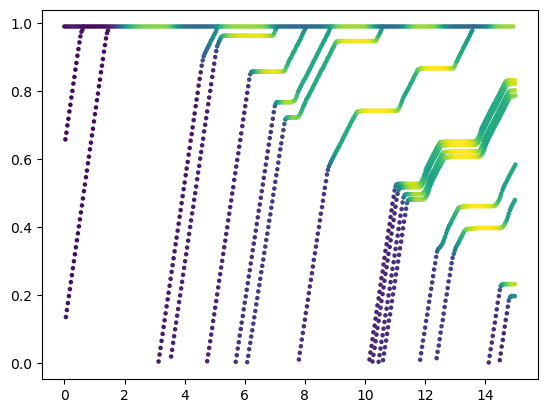

In [11]:
plt.scatter(coords_array[0][:, 1], coords_array[0][:, 0], c=values_array[0][:, 0], cmap='viridis', s=5)

In [12]:
# Load the saved dataset
def load_and_filter_dataset(num_simulations, T_PAST, T_PRED):
    # Load the dataset saved using np.savez
    data = np.load(f'highway/dataset_idm/processed_data_no_clip{num_simulations}.npz', allow_pickle=True)
    coords_array = data['coords_array']
    values_array = data['values_array']
    rhos_array = data['rhos_array']
    target_coords_array = data['target_coords_array']
    target_values_array = data['target_values_array']

    # Initialize lists to store filtered data
    filtered_coords = []
    filtered_values = []
    filtered_target_coords = []
    filtered_target_values = []
    t_starts = []
    shapes = []
    shapes_target = []

    # Loop through each simulation
    for k, (coords, values, target_coords, target_values) in enumerate(zip(coords_array, values_array, target_coords_array, target_values_array)):
        # Sample t_start from 2 to 5
        t_start = np.random.uniform(0, 5)

        # Filter coords and values for time between t_start and T_PAST
        time_filter = (coords[:, 1] >= t_start) & (coords[:, 1] <= t_start + T_PAST)
        filtered_coords_part = coords[time_filter]
        filtered_values_part = values[time_filter]

        # Remove rho values between -0.1 and 0.1
        rho_filter = (filtered_values_part[:,0] > 0.01)

        # Apply the mask only along the first dimension
        filtered_coords_part = filtered_coords_part[rho_filter]
        filtered_values_part = filtered_values_part[rho_filter]


        # Keep the coords with ID = -1 for time between t_start and t_start + T_PRED + T_PAST
        boundary_filter = (coords[:, 2] == -1) & (coords[:, 1] >= t_start) & (coords[:, 1] <= t_start + T_PRED + T_PAST)
        filtered_coords_boundary = coords[boundary_filter]
        filtered_values_boundary = values[boundary_filter]

        # Ensure target_coords is 2D and has a time dimension to filter
        if target_coords.ndim == 2 and target_coords.shape[1] >= 2:
            # Filter target_coords and target_values using the time filter
            target_time_filter = (target_coords[:, 1] >= t_start) & (target_coords[:, 1] <= t_start + T_PAST + T_PRED)
            filtered_target_coords_part = target_coords[target_time_filter] - np.array([0, t_start])
            filtered_target_values_part = target_values[target_time_filter]
        else:
            # If target_coords is not in the correct shape, skip filtering
            filtered_target_coords_part = target_coords - np.array([0, t_start])
            filtered_target_values_part = target_values

        # Combine the filtered parts
        combined_coords = np.vstack((filtered_coords_part, filtered_coords_boundary)) - np.array([0, t_start, 0])
        combined_values = np.vstack((filtered_values_part, filtered_values_boundary))

        shapes.append(filtered_coords_part.shape[0])
        shapes_target.append(filtered_target_coords_part.shape[0])

        # Add to the filtered data lists
        filtered_coords.append(combined_coords)
        filtered_values.append(combined_values)
        filtered_target_coords.append(filtered_target_coords_part)
        filtered_target_values.append(filtered_target_values_part)
        t_starts.append(t_start)


    # Convert the lists to numpy arrays
    filtered_coords_array = np.array(filtered_coords, dtype=object)
    filtered_values_array = np.array(filtered_values, dtype=object)
    filtered_target_coords_array = np.array(filtered_target_coords, dtype=object)
    filtered_target_values_array = np.array(filtered_target_values, dtype=object)
    t_starts_array = np.array(t_starts)

    return (rhos_array, filtered_target_coords_array, filtered_target_values_array,
            filtered_coords_array, filtered_values_array, t_starts_array, shapes, shapes_target)

# Example usage
T_PAST = 2  # Example value for T_PAST
T_PRED = 8   # Example value for T_PRED
rhos, target_coords, target_values, branch_coords, branch_values, t_starts, shapes, shapes_target = load_and_filter_dataset(30, T_PAST, T_PRED)
print(f"Filtered coords array shape: {branch_coords.shape}, Filtered values array shape: {branch_values.shape}")


Filtered coords array shape: (30,), Filtered values array shape: (30,)


In [13]:
def pad_to_shape_branch(coords, values, target_shape_boundary, target_shape_probe):
    # Separate boundary and probe data based on ID in coords
    boundary_data_coords = coords[coords[:, 2] == -1]
    probe_data_coords = coords[coords[:, 2] != -1]
    
    boundary_data_values = values[coords[:, 2] == -1]
    probe_data_values = values[coords[:, 2] != -1]
    
    # Truncate or pad boundary data to target_shape_boundary
    filtered_boundary_coords = boundary_data_coords[:target_shape_boundary]
    filtered_boundary_values = boundary_data_values[:target_shape_boundary]
    
    # Truncate or pad probe data to target_shape_probe
    if probe_data_coords.shape[0] < target_shape_probe:
        # Pad if probe data is smaller than target_shape_probe
        pad_size = target_shape_probe - probe_data_coords.shape[0]
        
        # Generate random values from existing probe data
        random_indices = np.random.choice(probe_data_coords.shape[0], size=pad_size)
        random_coords = probe_data_coords[random_indices]
        random_values = probe_data_values[random_indices]
        
        # Concatenate original and random padded data
        filtered_probe_coords = np.concatenate([probe_data_coords, random_coords], axis=0)
        filtered_probe_values = np.concatenate([probe_data_values, random_values], axis=0)
    else:
        # Truncate if probe data is larger than target_shape_probe
        filtered_probe_coords = probe_data_coords[:target_shape_probe]
        filtered_probe_values = probe_data_values[:target_shape_probe]

    # Combine boundary and probe data back together
    filtered_coords = np.vstack([filtered_boundary_coords, filtered_probe_coords])
    filtered_values = np.vstack([filtered_boundary_values, filtered_probe_values])

    return filtered_coords, filtered_values

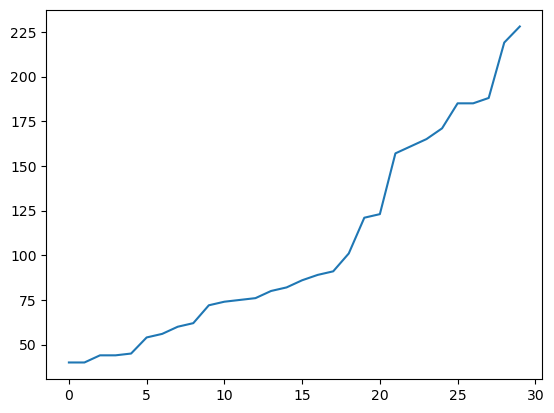

In [14]:
plt.plot(sorted(shapes))

In [19]:
num_boundary = len(np.where(branch_coords[0][:, 2] == -1)[0])
print(num_boundary)

# pad to shape of max_id
filtered_coords_values = [
    pad_to_shape_branch(coords, values, target_shape_boundary=num_boundary, target_shape_probe=200) 
    for coords, values in zip(branch_coords, branch_values)
]

# Split into separate lists if needed
filtered_coords_padded = np.array([item[0] for item in filtered_coords_values])
filtered_values_padded = np.array([item[1] for item in filtered_coords_values])

m_min = min(arr.shape[0] for arr in target_coords)

# Stack the arrays, trimming each to m_min rows
filtered_output_coords_padded = np.stack([arr[-m_min:] for arr in target_coords])
filtered_output_values_padded = np.stack([arr[-m_min:] for arr in target_values])

print(f"Filtered coords padded shape: {filtered_coords_padded.shape}, Filtered values padded shape: {filtered_values_padded.shape}")
print(f"rhos shape: {rhos.shape}, Filtered output coords padded shape: {filtered_output_coords_padded.shape}, Filtered output values padded shape: {filtered_output_values_padded.shape}")
print(f"t_starts shape: {t_starts.shape}")

180
Filtered coords padded shape: (30, 380, 3), Filtered values padded shape: (30, 380, 2)
rhos shape: (30, 101, 300), Filtered output coords padded shape: (30, 1943, 2), Filtered output values padded shape: (30, 1943)
t_starts shape: (30,)


(0.0, 1.0)

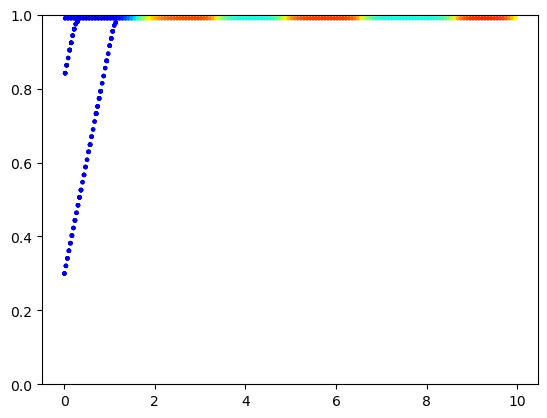

In [20]:
plt.scatter(filtered_coords_padded[0][:, 1], filtered_coords_padded[0][:, 0], c=filtered_values_padded[0][:, 0], cmap='jet', s=5, vmin=0, vmax=1)
plt.ylim([0, 1])

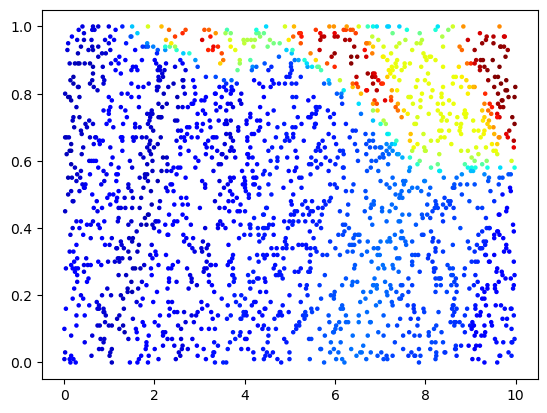

In [21]:
plt.scatter(filtered_output_coords_padded[0][:, 1], filtered_output_coords_padded[0][:, 0], c=filtered_output_values_padded[0], cmap='jet', s=5, vmin=0, vmax=1)

In [22]:
filtred_simulation_data = {
    'branch_coords': filtered_coords_padded.astype(np.float16),
    'branch_values': filtered_values_padded.astype(np.float16),
    'output_sensor_coords': filtered_output_coords_padded.astype(np.float16),
    'output_sensor_values': filtered_output_values_padded.astype(np.float16),
    'rho': rhos.astype(np.float16),
    'Nx': rhos.shape[1], 
    'Nt': rhos.shape[2],
    'Xmax': 1,
    'Tmax': 10,
    'P': 3000,
    'N': rhos.shape[0],
    't_pred': T_PRED,
    't_past': T_PAST,
    't_starts': t_starts.astype(np.float16)
}

# Save the data to an npz file
new_path = f'../datasets/sumo/sumo_idm_dataset_tpast{T_PAST}_tpred{T_PRED}.npz'
print(f"Saving the filtered data to {new_path}")
np.savez(new_path, **filtred_simulation_data)

Saving the filtered data to ../datasets/sumo/sumo_idm_dataset_tpast2_tpred8.npz
